# Tully-Fisher Secondary Target Sample

Demonstrate SQLite3 access to the TF targets in the secondary target database at NERSC.

In [1]:
import os
from astropy.io import ascii, fits
from astropy.table import join, hstack, vstack, unique, Table
from desispec.spectra import stack as specstack
from desispec.io import read_spectra, write_spectra

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=16)
mpl.rc('axes', titlesize='small')

In [3]:
import sqlite3
from contextlib import closing

## SQLite3 Query

See if we have a cached copy of the query results (in FITS format) before running this query.

In [4]:
# Change use_cached = False if we want to redo the query at some point.
use_cached = True

if os.path.exists('tf_targets.fits') and use_cached:
    tf_targets = Table.read('tf_targets.fits')
else:
    query = "select distinct pv.BRICKID, pv.OBJID, ifnull(pv.SGA_ID, 0), pv.POINTINGID, fd.TARGETID, fd.TARGET_RA, fd.TARGET_DEC, pv.PVTYPE, zd.Z, zd.ZERR, zd.SPECTYPE, zd.DELTACHI2, zd.ZWARN \
            from (select distinct BRICKID, OBJID, PVTYPE, SGA_ID, POINTINGID from proposals_pv \
            where (PVTYPE like 'TFT' or PVTYPE like 'EXT' or PVTYPE like 'SGA')) pv \
            inner join fibermap_daily fd \
            on (pv.BRICKID = fd.BRICKID) and (pv.OBJID = fd.BRICK_OBJID) \
            inner join zbest_daily zd \
            on zd.TARGETID=fd.TARGETID \
            group by pv.BRICKID, pv.OBJID, fd.TARGETID;"

    with closing(sqlite3.connect('/global/cfs/cdirs/desi/science/td/db/desi.db')) as db:
        with closing(db.cursor()) as cursor:
            rows = cursor.execute(query).fetchall()

    tf_targets = Table(list(map(list, zip(*rows))),
                        names=['BRICKID', 'OBJID', 'SGA_ID', 'POINTINGID', 'TARGETID', 'TARGET_RA', 'TARGET_DEC', 'PVTYPE', 'Z', 'ZERR', 'SPECTYPE', 'DELTACHI2', 'ZWARN'])
    
    # Cache output for later.
    tf_targets.write('tf_targets.fits', overwrite=True)

In [5]:
tf_targets

BRICKID,OBJID,SGA_ID,POINTINGID,TARGETID,TARGET_RA,TARGET_DEC,PVTYPE,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN
int64,int64,int64,int64,int64,float64,float64,bytes3,float64,float64,bytes6,float64,int64
167956,2666,0,1,39627103523572330,60.260698633107395,-29.594653554141743,SGA,0.06225767472039451,2.566800698793671e-06,GALAXY,3957.784563302994,0
169211,2910,0,1,39627108787424094,59.87701617620354,-29.27562410949489,TFT,0.06394433215715016,2.7439463599951238e-06,GALAXY,4087.5708914995193,0
169211,9005,0,1,39627108787430189,60.036826985164964,-29.189657862654347,TFT,0.10220542022824823,6.386613074895181e-06,GALAXY,3699.9883719980717,0
169214,2175,0,1,39627108800006271,60.73343272922586,-29.13329335660483,SGA,-0.0019957014509158224,4.131159871613317e-48,STAR,1.942668892225729e+84,1570
170465,4546,0,1,39627114047082946,58.61477932615988,-29.082494579381116,TFT,0.08456719016182049,7.306212756121691e-06,GALAXY,1132.7303842157125,0
170468,4286,0,1,39627114059665598,59.459719827649835,-29.048041429979463,TFT,-0.0019957014509158224,4.131159871613317e-48,STAR,1.942668892225729e+84,1570
172996,5125,0,1,39627124662866949,59.76729028360094,-28.53121753694664,TFT,0.06396365783309992,6.0179726478439966e-06,GALAXY,700.9088681489229,0
192684,235,0,1,616087959543742699,158.911700543051,-24.8360454305491,EXT,1.301258760641967,0.00011134371000224556,GALAXY,11.928453415632248,0
210990,1938,0,1,39627284021249938,84.70422386772135,-21.271101199437105,TFT,0.04586704883927905,2.7476859026724144e-06,GALAXY,7963.261393494904,0


In [6]:
np.unique(tf_targets['PVTYPE'], return_counts=True)

(<Column name='PVTYPE' dtype='bytes3' length=3>
 EXT
 SGA
 TFT,
 array([  90, 4642, 7830]))

## Plot Target Coordinates

In [7]:
def plot_radec(table):
    """Mollweide projection plot adapted to astro coordinates.
    
    Parameters
    ----------
    table : astropy.table.Table
        Data table with secondary target info.
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object to let user apply further plot manipulation.
    """
    fig, ax = plt.subplots(1,1, figsize=(8,4), subplot_kw={'projection': 'mollweide'})
    
    # Loop through unique classes.
    class_names = np.unique(table['PVTYPE'])
    for class_name in class_names:
        select = table['PVTYPE'] == class_name
        
        # Convert RA, Dec to radians.
        # Rotate the RA so that the plot goes 360->0 left to right.
        _ra = np.radians(180. - table[select]['TARGET_RA'])
        _dec = np.radians(table[select]['TARGET_DEC'])
        ax.scatter(_ra, _dec, alpha=0.5, s=5, label=class_name)

    # Clean up the plot and return the Figure object.
    ax.set(xticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
           xticklabels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h'])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(ls=':')
    
    ax.legend(fontsize=8, loc='lower right')
    fig.tight_layout()

    return fig;

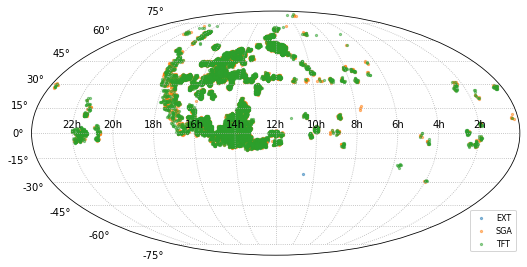

In [8]:
fig = plot_radec(tf_targets)

## Plot Target Redshifts

Extract good redshifts and plot the distributions as a function of target type.

In [9]:
isgoodz = (tf_targets['DELTACHI2']>= 25) & (tf_targets['ZWARN']==0)
np.sum(isgoodz)

11882

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


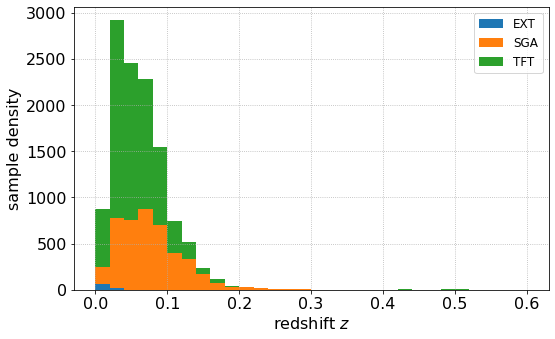

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)

zdata = []
pvtypes = np.unique(tf_targets['PVTYPE'])
for pvtype in pvtypes:
    ispvtype = tf_targets['PVTYPE'] == pvtype
    zdata.append(list(tf_targets[isgoodz & ispvtype]['Z']))

zbins = np.linspace(0,0.6,31)
ax.hist(zdata, bins=zbins, stacked=True, label=pvtypes)
ax.set(#ylim=(0,15),
       xlabel='redshift $z$',
       ylabel='sample density')
ax.grid(ls=':')

ax.legend(fontsize=12);